In [1]:
import pandas as pd
import json
import os
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt
%matplotlib inline
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)


x
x
x
x
x


### Data inladen 

    Load data for town called Ambridge
    data_path = './data/ambridge/'
    review_file = 'review.json'
    business_file = 'business.json'
    user_file = 'user.json'
    tip_file = 'tip.json'
    checkin_file = 'checkin.json'

    reviews = load_jsons(data_path, review_file)
    businesses = load_jsons(data_path, business_file)
    users = load_jsons(data_path, user_file)
    tips = load_jsons(data_path, tip_file)
    checkins = load_jsons(data_path, checkin_file)

In [2]:
# Loop over alle data 
for filename in os.listdir('data'):
    for file in os.listdir(f"data/{filename}"):
        pass


X
X
X
X
X


In [8]:
data_path = './data/dallas/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)


x
x
x
x
x


x
x
x
x
x


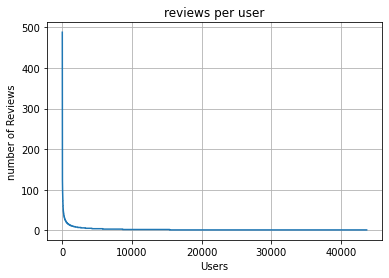

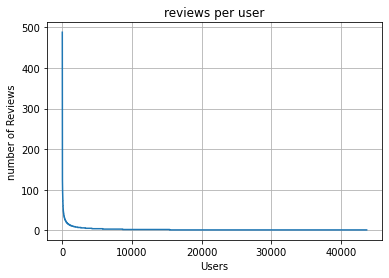

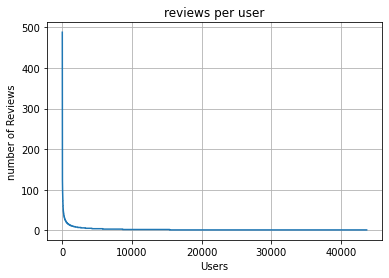

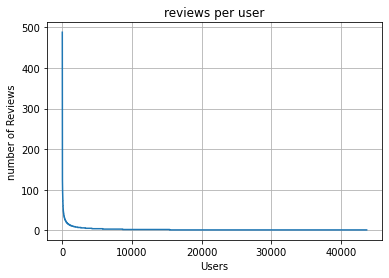

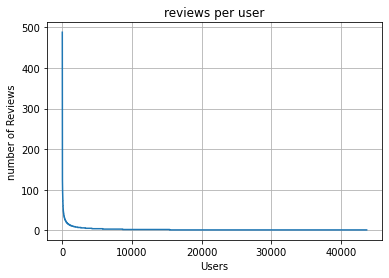

In [4]:
# Reviews per User plot (voor één gebied)

user = reviews.groupby("user_id")  
stars = user['stars']
stars = stars.apply(len)

# Plot
fig, (ax1) = plt.subplots(ncols=1)
ax1.plot(list(stars.sort_values(ascending=False)))
ax1.grid(True)
ax1.set_xlabel("Users")
ax1.set_ylabel("number of Reviews")
ax1.set_title("reviews per user")



In [9]:


def dataframe_BC(businesses):
    " Unpacks categories seprated by a ','  "
    
    dict_id_categorie = businesses[['business_id','categories','stars']]
    
    list_business = []
    list_categories = []
    list_stars = []
    
    for index,row in dict_id_categorie.iterrows():
        
        if index <= 300:
      
            if not row['categories'] is None:

                for categorie in row['categories'].split(","):
                    list_business.append(row['business_id'])
                    list_categories.append(categorie)
                    list_stars.append(row['stars'])

        
            
    Data = {'business_id': list_business,'categories':list_categories, 'stars': list_stars} 
    BC_dataframe = pd.DataFrame(data=Data)
    return BC_dataframe



def pivot_categories(df):
    "Creates a one-hot encoded matrix for categories."
    return df.pivot_table(index = 'business_id', columns = 'categories', aggfunc = 'size', fill_value=0)
 
    
def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)



def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c["predicted_rating"] = to_predict.apply(lambda row: predict_ids(similarity, ratings_test_c, row['user_id'], row["business_id"]),  axis=1)
    return ratings_test_c


### Helper functions for predict_ratings_content_based ###

def predict_ids(similarity, dataframe, userid, businessId):
    
    if businessId in similarity:
    # select right series from matrices and compute
        return predict_vectors(dataframe, userid, similarity[businessId])
    
    return 0


def predict_vectors(user_ratings, userid, similarities):
    
    # select only movies actually rated by user
    selected_user = user_ratings[user_ratings["user_id"] == userid][["business_id", "stars"]]
    
    selected_businesses = selected_user.set_index('business_id')

     
    # select corresponding similairties
    similarities_s = similarities[selected_businesses.index]

    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    

    relevant_ratings = selected_businesses.loc[similarities_s.index]
    

    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
  
    if(norm == 0):
        return 0
    
    similarities_s = pd.DataFrame(data=similarities_s.items(), columns=["business_id", "stars"])

    similarities_s = similarities_s.set_index('business_id')
   
    return np.mean(relevant_ratings['stars'] * similarities_s["stars"]) / sum(similarities_s["stars"])



def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted_rating']
    return (diff**2).mean()


def rmse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = np.sqrt(((predicted_ratings['stars'])**2 - (predicted_ratings['predicted_rating'])**2))
    return diff.mean()
 
    
    
def mae(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted_rating']
    return (diff).mean()

In [10]:
"dataframe hervormen"
dataframe = dataframe_BC(businesses)
display(dataframe)


"Utility matrix"
df_utility_categories = pivot_categories(dataframe)
display(df_utility_categories)


"similarity matrix"
df_similarity_categories = create_similarity_matrix_jaccard(df_utility_categories)
display(df_similarity_categories.head())


"predict ratings"
users = reviews[['user_id', 'business_id', 'stars']]
predicted_rating = predict_ratings(df_similarity_categories, df_utility_categories, users)
display(predicted_rating)


"mse ratings"
mse_categories = mse(predicted_rating)
print(f'mse for content based filtering: {mse_categories:.2f}')

"rsme ratings"
rmse_categories = rmse(predicted_rating)
print(f'rmse for content based filtering: {rmse_categories:.2f}')

"mae ratings"
mae_categories = mae(predicted_rating)
print(f'mae for content based filtering: {mae_categories:.2f}')


,business_id,categories,stars
0,IQJ769ftxu00hi_NkXQfcw,American (New),3.0
1,IQJ769ftxu00hi_NkXQfcw,Restaurants,3.0
2,7FPYgKjPu7c2qTcRyBq5DQ,Restaurants,2.5
3,7FPYgKjPu7c2qTcRyBq5DQ,Chinese,2.5
4,Xny25ewLkn6XH3KvJzsBpQ,Food,2.5
...,...,...,...
94,PmG45euNFEQkXG5yaVYKWA,Restaurants,4.5
95,PmG45euNFEQkXG5yaVYKWA,Fast Food,4.5
96,eFnw1ZN-w1Db92gJYwNoeQ,Fruits & Veggies,4.5
97,eFnw1ZN-w1Db92gJYwNoeQ,Specialty Food,4.5


,business_id,categories,stars
0,IQJ769ftxu00hi_NkXQfcw,American (New),3.0
1,IQJ769ftxu00hi_NkXQfcw,Restaurants,3.0
2,7FPYgKjPu7c2qTcRyBq5DQ,Restaurants,2.5
3,7FPYgKjPu7c2qTcRyBq5DQ,Chinese,2.5
4,Xny25ewLkn6XH3KvJzsBpQ,Food,2.5
...,...,...,...
94,PmG45euNFEQkXG5yaVYKWA,Restaurants,4.5
95,PmG45euNFEQkXG5yaVYKWA,Fast Food,4.5
96,eFnw1ZN-w1Db92gJYwNoeQ,Fruits & Veggies,4.5
97,eFnw1ZN-w1Db92gJYwNoeQ,Specialty Food,4.5


,business_id,categories,stars
0,IQJ769ftxu00hi_NkXQfcw,American (New),3.0
1,IQJ769ftxu00hi_NkXQfcw,Restaurants,3.0
2,7FPYgKjPu7c2qTcRyBq5DQ,Restaurants,2.5
3,7FPYgKjPu7c2qTcRyBq5DQ,Chinese,2.5
4,Xny25ewLkn6XH3KvJzsBpQ,Food,2.5
...,...,...,...
94,PmG45euNFEQkXG5yaVYKWA,Restaurants,4.5
95,PmG45euNFEQkXG5yaVYKWA,Fast Food,4.5
96,eFnw1ZN-w1Db92gJYwNoeQ,Fruits & Veggies,4.5
97,eFnw1ZN-w1Db92gJYwNoeQ,Specialty Food,4.5


,business_id,categories,stars
0,IQJ769ftxu00hi_NkXQfcw,American (New),3.0
1,IQJ769ftxu00hi_NkXQfcw,Restaurants,3.0
2,7FPYgKjPu7c2qTcRyBq5DQ,Restaurants,2.5
3,7FPYgKjPu7c2qTcRyBq5DQ,Chinese,2.5
4,Xny25ewLkn6XH3KvJzsBpQ,Food,2.5
...,...,...,...
94,PmG45euNFEQkXG5yaVYKWA,Restaurants,4.5
95,PmG45euNFEQkXG5yaVYKWA,Fast Food,4.5
96,eFnw1ZN-w1Db92gJYwNoeQ,Fruits & Veggies,4.5
97,eFnw1ZN-w1Db92gJYwNoeQ,Specialty Food,4.5


,business_id,categories,stars
0,IQJ769ftxu00hi_NkXQfcw,American (New),3.0
1,IQJ769ftxu00hi_NkXQfcw,Restaurants,3.0
2,7FPYgKjPu7c2qTcRyBq5DQ,Restaurants,2.5
3,7FPYgKjPu7c2qTcRyBq5DQ,Chinese,2.5
4,Xny25ewLkn6XH3KvJzsBpQ,Food,2.5
...,...,...,...
94,PmG45euNFEQkXG5yaVYKWA,Restaurants,4.5
95,PmG45euNFEQkXG5yaVYKWA,Fast Food,4.5
96,eFnw1ZN-w1Db92gJYwNoeQ,Fruits & Veggies,4.5
97,eFnw1ZN-w1Db92gJYwNoeQ,Specialty Food,4.5


categories,American (Traditional),Auto Repair,Bars,Brazilian,Breakfast & Brunch,Buffets,Burgers,Chicken Shop,Chicken Wings,Chinese,...,Family Practice,Fast Food,Food,Fruits & Veggies,Grocery,Party Bus Rentals,Party Supplies,Restaurants,Sandwiches,Wedding Planning
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4U7srDCkFIxEk7tvKyu3Xw,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7FPYgKjPu7c2qTcRyBq5DQ,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7PdNq6hdzVvil8zuVJ6loQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7j5yndEexyQn9cpVXLIIpw,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81RW1hZc9YL6HolVWjeTBw,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BqsIt1BQKzS-hEKLYzBm7g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
F8Xdd9pqpgfdZxIIh5_tLQ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
GvMirXtuhQHO3ehnb1gGNw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


categories,American (Traditional),Auto Repair,Bars,Brazilian,Breakfast & Brunch,Buffets,Burgers,Chicken Shop,Chicken Wings,Chinese,...,Family Practice,Fast Food,Food,Fruits & Veggies,Grocery,Party Bus Rentals,Party Supplies,Restaurants,Sandwiches,Wedding Planning
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4U7srDCkFIxEk7tvKyu3Xw,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7FPYgKjPu7c2qTcRyBq5DQ,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7PdNq6hdzVvil8zuVJ6loQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7j5yndEexyQn9cpVXLIIpw,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81RW1hZc9YL6HolVWjeTBw,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BqsIt1BQKzS-hEKLYzBm7g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
F8Xdd9pqpgfdZxIIh5_tLQ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
GvMirXtuhQHO3ehnb1gGNw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


categories,American (Traditional),Auto Repair,Bars,Brazilian,Breakfast & Brunch,Buffets,Burgers,Chicken Shop,Chicken Wings,Chinese,...,Family Practice,Fast Food,Food,Fruits & Veggies,Grocery,Party Bus Rentals,Party Supplies,Restaurants,Sandwiches,Wedding Planning
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4U7srDCkFIxEk7tvKyu3Xw,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7FPYgKjPu7c2qTcRyBq5DQ,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7PdNq6hdzVvil8zuVJ6loQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7j5yndEexyQn9cpVXLIIpw,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81RW1hZc9YL6HolVWjeTBw,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BqsIt1BQKzS-hEKLYzBm7g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
F8Xdd9pqpgfdZxIIh5_tLQ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
GvMirXtuhQHO3ehnb1gGNw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


categories,American (Traditional),Auto Repair,Bars,Brazilian,Breakfast & Brunch,Buffets,Burgers,Chicken Shop,Chicken Wings,Chinese,...,Family Practice,Fast Food,Food,Fruits & Veggies,Grocery,Party Bus Rentals,Party Supplies,Restaurants,Sandwiches,Wedding Planning
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4U7srDCkFIxEk7tvKyu3Xw,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7FPYgKjPu7c2qTcRyBq5DQ,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7PdNq6hdzVvil8zuVJ6loQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7j5yndEexyQn9cpVXLIIpw,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81RW1hZc9YL6HolVWjeTBw,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BqsIt1BQKzS-hEKLYzBm7g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
F8Xdd9pqpgfdZxIIh5_tLQ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
GvMirXtuhQHO3ehnb1gGNw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


categories,American (Traditional),Auto Repair,Bars,Brazilian,Breakfast & Brunch,Buffets,Burgers,Chicken Shop,Chicken Wings,Chinese,...,Family Practice,Fast Food,Food,Fruits & Veggies,Grocery,Party Bus Rentals,Party Supplies,Restaurants,Sandwiches,Wedding Planning
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4U7srDCkFIxEk7tvKyu3Xw,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7FPYgKjPu7c2qTcRyBq5DQ,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7PdNq6hdzVvil8zuVJ6loQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7j5yndEexyQn9cpVXLIIpw,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81RW1hZc9YL6HolVWjeTBw,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BqsIt1BQKzS-hEKLYzBm7g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
F8Xdd9pqpgfdZxIIh5_tLQ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
GvMirXtuhQHO3ehnb1gGNw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


business_id,1bXYF9P0K3rbbERYCm_bdQ,4U7srDCkFIxEk7tvKyu3Xw,7FPYgKjPu7c2qTcRyBq5DQ,7PdNq6hdzVvil8zuVJ6loQ,7j5yndEexyQn9cpVXLIIpw,81RW1hZc9YL6HolVWjeTBw,BqsIt1BQKzS-hEKLYzBm7g,F8Xdd9pqpgfdZxIIh5_tLQ,GvMirXtuhQHO3ehnb1gGNw,IQJ769ftxu00hi_NkXQfcw,...,Xny25ewLkn6XH3KvJzsBpQ,YCPN7WrIFweh1OWgK9g71A,bCKYY-cfFclOzuP4CVgS2g,dUhYjBM3QHkPKV7Z63ottQ,eFnw1ZN-w1Db92gJYwNoeQ,eY8seIkG0WwgTogxO3e6TA,juJCB5Fgd80JfdGIbIFKLw,vm17ueG3HPdlC0CQy82Wxw,w1ZaGNJdwMQa3QvIxAW4Sg,x92N9BWbFJGf55wJS_QFZg
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,1.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.000
4U7srDCkFIxEk7tvKyu3Xw,0.0,1.00,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,...,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.125
7FPYgKjPu7c2qTcRyBq5DQ,0.0,0.00,1.000000,0.00,0.166667,0.166667,0.166667,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.200,0.000000,0.000
7PdNq6hdzVvil8zuVJ6loQ,0.0,0.25,0.000000,1.00,0.000000,0.142857,0.142857,0.200000,0.0,0.250000,...,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.166667,0.250
7j5yndEexyQn9cpVXLIIpw,0.0,0.00,0.166667,0.00,1.000000,0.111111,0.111111,0.142857,0.0,0.000000,...,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.125,0.000000,0.000


business_id,1bXYF9P0K3rbbERYCm_bdQ,4U7srDCkFIxEk7tvKyu3Xw,7FPYgKjPu7c2qTcRyBq5DQ,7PdNq6hdzVvil8zuVJ6loQ,7j5yndEexyQn9cpVXLIIpw,81RW1hZc9YL6HolVWjeTBw,BqsIt1BQKzS-hEKLYzBm7g,F8Xdd9pqpgfdZxIIh5_tLQ,GvMirXtuhQHO3ehnb1gGNw,IQJ769ftxu00hi_NkXQfcw,...,Xny25ewLkn6XH3KvJzsBpQ,YCPN7WrIFweh1OWgK9g71A,bCKYY-cfFclOzuP4CVgS2g,dUhYjBM3QHkPKV7Z63ottQ,eFnw1ZN-w1Db92gJYwNoeQ,eY8seIkG0WwgTogxO3e6TA,juJCB5Fgd80JfdGIbIFKLw,vm17ueG3HPdlC0CQy82Wxw,w1ZaGNJdwMQa3QvIxAW4Sg,x92N9BWbFJGf55wJS_QFZg
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,1.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.000
4U7srDCkFIxEk7tvKyu3Xw,0.0,1.00,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,...,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.125
7FPYgKjPu7c2qTcRyBq5DQ,0.0,0.00,1.000000,0.00,0.166667,0.166667,0.166667,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.200,0.000000,0.000
7PdNq6hdzVvil8zuVJ6loQ,0.0,0.25,0.000000,1.00,0.000000,0.142857,0.142857,0.200000,0.0,0.250000,...,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.166667,0.250
7j5yndEexyQn9cpVXLIIpw,0.0,0.00,0.166667,0.00,1.000000,0.111111,0.111111,0.142857,0.0,0.000000,...,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.125,0.000000,0.000


business_id,1bXYF9P0K3rbbERYCm_bdQ,4U7srDCkFIxEk7tvKyu3Xw,7FPYgKjPu7c2qTcRyBq5DQ,7PdNq6hdzVvil8zuVJ6loQ,7j5yndEexyQn9cpVXLIIpw,81RW1hZc9YL6HolVWjeTBw,BqsIt1BQKzS-hEKLYzBm7g,F8Xdd9pqpgfdZxIIh5_tLQ,GvMirXtuhQHO3ehnb1gGNw,IQJ769ftxu00hi_NkXQfcw,...,Xny25ewLkn6XH3KvJzsBpQ,YCPN7WrIFweh1OWgK9g71A,bCKYY-cfFclOzuP4CVgS2g,dUhYjBM3QHkPKV7Z63ottQ,eFnw1ZN-w1Db92gJYwNoeQ,eY8seIkG0WwgTogxO3e6TA,juJCB5Fgd80JfdGIbIFKLw,vm17ueG3HPdlC0CQy82Wxw,w1ZaGNJdwMQa3QvIxAW4Sg,x92N9BWbFJGf55wJS_QFZg
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,1.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.000
4U7srDCkFIxEk7tvKyu3Xw,0.0,1.00,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,...,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.125
7FPYgKjPu7c2qTcRyBq5DQ,0.0,0.00,1.000000,0.00,0.166667,0.166667,0.166667,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.200,0.000000,0.000
7PdNq6hdzVvil8zuVJ6loQ,0.0,0.25,0.000000,1.00,0.000000,0.142857,0.142857,0.200000,0.0,0.250000,...,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.166667,0.250
7j5yndEexyQn9cpVXLIIpw,0.0,0.00,0.166667,0.00,1.000000,0.111111,0.111111,0.142857,0.0,0.000000,...,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.125,0.000000,0.000


business_id,1bXYF9P0K3rbbERYCm_bdQ,4U7srDCkFIxEk7tvKyu3Xw,7FPYgKjPu7c2qTcRyBq5DQ,7PdNq6hdzVvil8zuVJ6loQ,7j5yndEexyQn9cpVXLIIpw,81RW1hZc9YL6HolVWjeTBw,BqsIt1BQKzS-hEKLYzBm7g,F8Xdd9pqpgfdZxIIh5_tLQ,GvMirXtuhQHO3ehnb1gGNw,IQJ769ftxu00hi_NkXQfcw,...,Xny25ewLkn6XH3KvJzsBpQ,YCPN7WrIFweh1OWgK9g71A,bCKYY-cfFclOzuP4CVgS2g,dUhYjBM3QHkPKV7Z63ottQ,eFnw1ZN-w1Db92gJYwNoeQ,eY8seIkG0WwgTogxO3e6TA,juJCB5Fgd80JfdGIbIFKLw,vm17ueG3HPdlC0CQy82Wxw,w1ZaGNJdwMQa3QvIxAW4Sg,x92N9BWbFJGf55wJS_QFZg
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,1.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.000
4U7srDCkFIxEk7tvKyu3Xw,0.0,1.00,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,...,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.125
7FPYgKjPu7c2qTcRyBq5DQ,0.0,0.00,1.000000,0.00,0.166667,0.166667,0.166667,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.200,0.000000,0.000
7PdNq6hdzVvil8zuVJ6loQ,0.0,0.25,0.000000,1.00,0.000000,0.142857,0.142857,0.200000,0.0,0.250000,...,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.166667,0.250
7j5yndEexyQn9cpVXLIIpw,0.0,0.00,0.166667,0.00,1.000000,0.111111,0.111111,0.142857,0.0,0.000000,...,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.125,0.000000,0.000


business_id,1bXYF9P0K3rbbERYCm_bdQ,4U7srDCkFIxEk7tvKyu3Xw,7FPYgKjPu7c2qTcRyBq5DQ,7PdNq6hdzVvil8zuVJ6loQ,7j5yndEexyQn9cpVXLIIpw,81RW1hZc9YL6HolVWjeTBw,BqsIt1BQKzS-hEKLYzBm7g,F8Xdd9pqpgfdZxIIh5_tLQ,GvMirXtuhQHO3ehnb1gGNw,IQJ769ftxu00hi_NkXQfcw,...,Xny25ewLkn6XH3KvJzsBpQ,YCPN7WrIFweh1OWgK9g71A,bCKYY-cfFclOzuP4CVgS2g,dUhYjBM3QHkPKV7Z63ottQ,eFnw1ZN-w1Db92gJYwNoeQ,eY8seIkG0WwgTogxO3e6TA,juJCB5Fgd80JfdGIbIFKLw,vm17ueG3HPdlC0CQy82Wxw,w1ZaGNJdwMQa3QvIxAW4Sg,x92N9BWbFJGf55wJS_QFZg
business_id,,,,,,,,,,,,,,,,,,,,,
1bXYF9P0K3rbbERYCm_bdQ,1.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.000
4U7srDCkFIxEk7tvKyu3Xw,0.0,1.00,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,...,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.125
7FPYgKjPu7c2qTcRyBq5DQ,0.0,0.00,1.000000,0.00,0.166667,0.166667,0.166667,0.250000,0.0,0.000000,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.200,0.000000,0.000
7PdNq6hdzVvil8zuVJ6loQ,0.0,0.25,0.000000,1.00,0.000000,0.142857,0.142857,0.200000,0.0,0.250000,...,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.166667,0.250
7j5yndEexyQn9cpVXLIIpw,0.0,0.00,0.166667,0.00,1.000000,0.111111,0.111111,0.142857,0.0,0.000000,...,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.125,0.000000,0.000


,user_id,business_id,stars,predicted_rating
0,YnRHtpyLi2K0UUGChDCVBg,IQJ769ftxu00hi_NkXQfcw,1.0,1.0
1,NQ2md3SAQxpQI_aa1XWJ4A,IQJ769ftxu00hi_NkXQfcw,5.0,5.0
2,calfeiA414jjSqJlyv14qg,IQJ769ftxu00hi_NkXQfcw,4.0,4.0
3,zAFSF_hmQZiCOJcV3dZDng,IQJ769ftxu00hi_NkXQfcw,3.0,3.0
4,EhrPT-VGrjmvrEadMvENHQ,IQJ769ftxu00hi_NkXQfcw,4.0,2.0
...,...,...,...,...
1234,aejM9aoISAanmLgnbok0rQ,PmG45euNFEQkXG5yaVYKWA,3.0,3.0
1235,6c0lS8VP4EXyMefnJgvphg,PmG45euNFEQkXG5yaVYKWA,4.0,4.0
1236,pvGbA6QCKkVVYM_UYkG6uw,PmG45euNFEQkXG5yaVYKWA,5.0,5.0
1237,8aYaaeAuWeH6VOR0saxz7Q,eFnw1ZN-w1Db92gJYwNoeQ,5.0,5.0


mse for content based filtering: 0.33
rmse for content based filtering: 0.20
mae for content based filtering: 0.13


,user_id,business_id,stars,predicted_rating
0,YnRHtpyLi2K0UUGChDCVBg,IQJ769ftxu00hi_NkXQfcw,1.0,1.0
1,NQ2md3SAQxpQI_aa1XWJ4A,IQJ769ftxu00hi_NkXQfcw,5.0,5.0
2,calfeiA414jjSqJlyv14qg,IQJ769ftxu00hi_NkXQfcw,4.0,4.0
3,zAFSF_hmQZiCOJcV3dZDng,IQJ769ftxu00hi_NkXQfcw,3.0,3.0
4,EhrPT-VGrjmvrEadMvENHQ,IQJ769ftxu00hi_NkXQfcw,4.0,2.0
...,...,...,...,...
1234,aejM9aoISAanmLgnbok0rQ,PmG45euNFEQkXG5yaVYKWA,3.0,3.0
1235,6c0lS8VP4EXyMefnJgvphg,PmG45euNFEQkXG5yaVYKWA,4.0,4.0
1236,pvGbA6QCKkVVYM_UYkG6uw,PmG45euNFEQkXG5yaVYKWA,5.0,5.0
1237,8aYaaeAuWeH6VOR0saxz7Q,eFnw1ZN-w1Db92gJYwNoeQ,5.0,5.0


,user_id,business_id,stars,predicted_rating
0,YnRHtpyLi2K0UUGChDCVBg,IQJ769ftxu00hi_NkXQfcw,1.0,1.0
1,NQ2md3SAQxpQI_aa1XWJ4A,IQJ769ftxu00hi_NkXQfcw,5.0,5.0
2,calfeiA414jjSqJlyv14qg,IQJ769ftxu00hi_NkXQfcw,4.0,4.0
3,zAFSF_hmQZiCOJcV3dZDng,IQJ769ftxu00hi_NkXQfcw,3.0,3.0
4,EhrPT-VGrjmvrEadMvENHQ,IQJ769ftxu00hi_NkXQfcw,4.0,2.0
...,...,...,...,...
1234,aejM9aoISAanmLgnbok0rQ,PmG45euNFEQkXG5yaVYKWA,3.0,3.0
1235,6c0lS8VP4EXyMefnJgvphg,PmG45euNFEQkXG5yaVYKWA,4.0,4.0
1236,pvGbA6QCKkVVYM_UYkG6uw,PmG45euNFEQkXG5yaVYKWA,5.0,5.0
1237,8aYaaeAuWeH6VOR0saxz7Q,eFnw1ZN-w1Db92gJYwNoeQ,5.0,5.0


,user_id,business_id,stars,predicted_rating
0,YnRHtpyLi2K0UUGChDCVBg,IQJ769ftxu00hi_NkXQfcw,1.0,1.0
1,NQ2md3SAQxpQI_aa1XWJ4A,IQJ769ftxu00hi_NkXQfcw,5.0,5.0
2,calfeiA414jjSqJlyv14qg,IQJ769ftxu00hi_NkXQfcw,4.0,4.0
3,zAFSF_hmQZiCOJcV3dZDng,IQJ769ftxu00hi_NkXQfcw,3.0,3.0
4,EhrPT-VGrjmvrEadMvENHQ,IQJ769ftxu00hi_NkXQfcw,4.0,2.0
...,...,...,...,...
1234,aejM9aoISAanmLgnbok0rQ,PmG45euNFEQkXG5yaVYKWA,3.0,3.0
1235,6c0lS8VP4EXyMefnJgvphg,PmG45euNFEQkXG5yaVYKWA,4.0,4.0
1236,pvGbA6QCKkVVYM_UYkG6uw,PmG45euNFEQkXG5yaVYKWA,5.0,5.0
1237,8aYaaeAuWeH6VOR0saxz7Q,eFnw1ZN-w1Db92gJYwNoeQ,5.0,5.0


,user_id,business_id,stars,predicted_rating
0,YnRHtpyLi2K0UUGChDCVBg,IQJ769ftxu00hi_NkXQfcw,1.0,1.0
1,NQ2md3SAQxpQI_aa1XWJ4A,IQJ769ftxu00hi_NkXQfcw,5.0,5.0
2,calfeiA414jjSqJlyv14qg,IQJ769ftxu00hi_NkXQfcw,4.0,4.0
3,zAFSF_hmQZiCOJcV3dZDng,IQJ769ftxu00hi_NkXQfcw,3.0,3.0
4,EhrPT-VGrjmvrEadMvENHQ,IQJ769ftxu00hi_NkXQfcw,4.0,2.0
...,...,...,...,...
1234,aejM9aoISAanmLgnbok0rQ,PmG45euNFEQkXG5yaVYKWA,3.0,3.0
1235,6c0lS8VP4EXyMefnJgvphg,PmG45euNFEQkXG5yaVYKWA,4.0,4.0
1236,pvGbA6QCKkVVYM_UYkG6uw,PmG45euNFEQkXG5yaVYKWA,5.0,5.0
1237,8aYaaeAuWeH6VOR0saxz7Q,eFnw1ZN-w1Db92gJYwNoeQ,5.0,5.0


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


mse for content based filtering: 0.33
rmse for content based filtering: 0.20
mae for content based filtering: 0.13
mse for content based filtering: 0.33
rmse for content based filtering: 0.20
mae for content based filtering: 0.13
mse for content based filtering: 0.33
rmse for content based filtering: 0.20
mae for content based filtering: 0.13
mse for content based filtering: 0.33
rmse for content based filtering: 0.20
mae for content based filtering: 0.13


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
